# Digit Recognizer using CNN Keras on MNIST

Fengping Wang     
Email: Fengping5566@gmail.com  
Language:  Pyton 3

# 1. Library Preparation

In [110]:
# import all librarys
import numpy as np 
import pandas as pd 
import itertools
import matplotlib.pyplot as plt
from collections import Counter 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline 

In [111]:
from keras.models import Sequential, load_model 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

In [112]:
import os
print(os.listdir("../input"))

['sample_submission.csv', 'test.csv', 'train.csv']


# 2. Dataset Preparation

# 2.1) Load Dataset

In [113]:
train_org = pd.read_csv('../input/train.csv')
test_org = pd.read_csv('../input/test.csv')
train = train_org.copy()
test = test_org.copy()
print(train.shape)
train.head(2)

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 2.2) Check Unbalanced Data

First, we take a quick look at the trianing dataset. It has 42000 rows and 785 columns. for each sample, it has a label indicating true digit and 784 pixels. 

In [114]:
cnt_train = Counter(train['label'])
cnt_train

Counter({1: 4684,
         0: 4132,
         4: 4072,
         7: 4401,
         3: 4351,
         5: 3795,
         8: 4063,
         9: 4188,
         2: 4177,
         6: 4137})

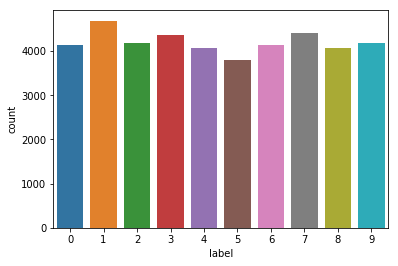

In [115]:
sns.countplot(train['label'])

we have similar counts for the 10 digits. It's a pretty balanced distributed dataset. But before diving into modeling, we stil need to check for missing values which migbe be a big truble after. 

# 2.3) Check Missing Data

In [116]:
train.isnull().any().describe()

count       785
unique        1
top       False
freq        785
dtype: object

In [117]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

We all got False, so there is no missing value involved in both train and test datasets. That means no corrupted images here, then now we dan dive to analysis.  Before that, let's take a look at these input digits;

# 2.4) Quick Look of Data

In [118]:
X = train.iloc[:,1:]
Y = train.iloc[:,0]
seed = 64
np.random.seed(seed)
x_train , x_test , y_train , y_test = train_test_split(X, Y, 
                                                       test_size = 0.15, 
                                                       random_state = seed)

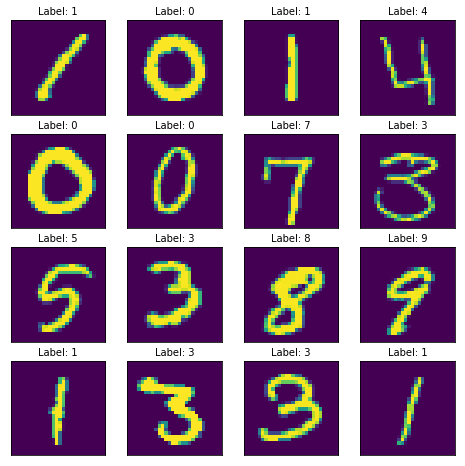

In [119]:
n_row = 4
n_col = 4
plt.figure(figsize = (8, 8))
for i in range(n_row * n_col):  
    plt.subplot(n_row, n_col, i + 1)
    grid_data = X.iloc[i].values.reshape(28,28)
    plt.imshow(grid_data,interpolation = 'nearest')
    title_text = 'Label: ' + str(Y.iloc[i])
    plt.title(title_text, size = 10)
    plt.xticks(())
    plt.yticks(())
plt.show()

#  2.5) Data Normalization 

We use grayscale normalization to reduce the effect of illumination's differences. 

In [120]:
X = X.astype("float32") / 255.0
Y = Y.astype("float32") / 255.0
test = test.astype("float32") / 255.0

# 2.6) Reshape to Match Keras's Application

In [121]:
# reshape(examples, height, width, channels)
x_train = x_train.values.reshape(-1, 28, 28, 1)
x_test = x_test.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1) 

# 2.7) One Hot Encoding

In [122]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# 3. Model Building: Convolutional Neural Network

# 3.1) CNN Introduction 

Usually,  when it comes to Image Recognition, then CNN's are the best. The Biggest Challenge is picking the Right model by understanding the Data rather than Tuning parameters of other models.

First. let's take a quick look at Conveloutoinal Neural Network(ConvNets).   
A simple ConvNet is a sequence of layers, and every layer of a ConvNet transforms one volume of activations to another through a differentiable function.   
We use three main types of layers to build ConvNet architectures:   
+++Input Layer  
+++Hidden Layer:   
Convolutional Layer  
Pooling Layer  
Fully-Connected Layer   
(Normalisation layer, Flatten Layer)  
+++Output Layer  
We will stack these layers to form a full ConvNet architecture. The Input Layer and Output Layer are easy to understand. The most important one is the Hidden Layer.
1. Convolutional layer: A layer that consists of a set of “filters”. The filters take a subset of the input data at a time, but are applied across the full input (by sweeping over the input). The operations performed by this layer are still linear/matrix multiplications, but they go through an activation function at the output, which is usually a non-linear operation.
2. Pooling layer:  A pooling layer effectively down samples the output of the prior layer, reducing the number of operations required for all the following layers, but still passing on the valid information from the previous layer.
5. Dense/fully connected layer: A linear operation in which every input is connected to every output by a weight (so there are n_inputs * n_outputs weights - which can be a lot!). Generally followed by a non-linear activation function.  
+++Normalisation layer: Used at the input for feature scaling, and in batch normalisation at hidden layers.  
+++Flatten Layer: Flattens the input. Does not affect the batch size.

For this project, we use Sequential Keras API, which is just a linear stack of layers. We add one layer at a time starting from input.
1. Input Layer: Build model and take the import.
2. Hidden Layer --->  Add Convolutoinal Layers with Batch Normalization.   
+++Convolutoinal Layers are the Building blocks of ConvNets.Convolutional Layers has set of Independent Filters whose depth is equal to Input and other dimensions can be set manually. These Filters when convolved over the Input Image produce Feature Maps. It includes some HyperParameters such as The number of filters, Dimensions of Filter (F), Stride (S), Padding(P) , Activation Function etc. which we input manually. Let the Input Volume Size be deonted by (W) ,  
Then, the Output will have Dimensions given by --> (Height, Width) = ( ( W − F + 2P ) / S ) + 1  
And the Depth will be equal to Number of Filters Specified.  
+++Also, We add Batch Normalization where we acheive Zero mean and Variance one. It scales down outliers and forces the network to learn features in a distributed way, not relying too much on a Particular Weight and makes the model better Generalize the Images. 
3. Hidden Layer --->  Add Pooling Layers with Dropout.   
+++Poolings Layers are re used for Dimensionality Reduction or DownSampling the Input. These are used where we have lot of Input Features. It reduces the amount of Parameters and Computational power required drastically, thus reducing Overfitting. These along with Convolutional layers are able to learn more Complex features of the Image.   
+++Also we add Dropout to aviod overfitting. his randomly drops some percentage of neurons, and thus the weights gets Re-Aligned. The remaining Neurons learn more features and this reduces the dependency on any one Neuron. DropOut is a Regularization Technique, which Penalizes the Parameters. Generally we set the DropOutRate between 0.2-0.5.
4. Hidden Layer ---> Add Full Connected Layer with Faltten.  
+++ Add Flatten layer to map the input to a 1D vector.  
+++Add Fully connected Layers after some convolutional/pooling layers. It combines all the Features of the Previous Layers.    
5. Ouput Layer:  Add the Output Layer.   
It has units equal to the number of classes to be identified. Here, we use 'sigmoid' function if it is Binary Classification otherwise 'softmax' activation function in case of Multi-Class Classification.

# 3.2) ConvNet Building

In [123]:
# intilize model 
model = Sequential()

# Input Layer + Hidden Layer: 1st Convolution layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last',
                 input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())

# Hidden Layer: 1st Pooling layer
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
model.add(Dropout(0.25))

# Hidden Layer: 2nd Convolution layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'))
model.add(BatchNormalization())

# Hidden Layer: 2nd Pooling layer
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
model.add(Dropout(0.25))

# Hidden Layer: Flatten layer 
model.add(Flatten())

# Hidden Layer: Full Connected Layer 
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(10, activation='softmax'))

# 3.3) Model Summary

In [124]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_25 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_26 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 64)        18496     
__________

# 3.4) Learning Process

Before Training the model, we need to configure the Learning process.   
Neural networks are often trained by gradient descent on the weights of a cost function. That means, you define a cost function for a neural network, and your goal is to find the weights that can minimize this cost function. It's a optimization problem.  Here The weights are discovered via an empirical optimization procedure called stochastic gradient descent, where the model paramaters (here weights and biases in the network) are updated in a way to decrease the cost function.   
The amount of change to the model during each step of this search process, or the step size, is called the “learning rate” . It defines how to update the parameters, and controls the rate or speed at which the model learns..    
Here, you can also think of a neural networks loss function as a surface, where each direction you can move in represents the value of a weight. Gradient descent is like taking leaps in the current direction of the slope, and the learning rate is like the length of the leap you take.  
Mathematically, w1_new= w1 + (learning rate)* (derivative of cost function wrt w1)
Generally, a large learning rate allows the model to learn faster, at the cost of arriving on a sub-optimal final set of weights. A smaller learning rate may allow the model to learn a more optimal or even globally optimal set of weights but may take significantly longer to train.
The learning rate may, in fact, be the most important hyperparameter to configure for your model.
There are 3 types of learning rate sepfication. 
1. Constant Learning Rate
2. Learning Rate Schedules:  
Learning rate schedules seek to adjust the learning rate during training by reducing the learning rate according to a pre-defined schedule. Common learning rate schedules include time-based decay, step decay and exponential decay.  
3. Adaptive Learning Rate Methods:   
The performance of the model on the training dataset can be monitored by the learning algorithm and the learning rate can be adjusted in response.An adaptive learning rate method will generally outperform a model with a badly configured learning rate.Although no single method works best on all problems, there are three adaptive learning rate methods that have proven to be robust over many types of neural network architectures and problem types. They are AdaGrad, RMSProp, and Adam, and all maintain and adapt learning rates for each of the weights in the model. Perhaps the most popular is Adam, as it builds upon RMSProp and adds momentum.

Moreover, even the Adaptive Learning Rate Method itself does a learning rate decay, we can still combine it with earning rate decay to imporve it. ' Though conventional wisdom suggests that Adam does not require tuning, we find that tuning the initial learning rate and decay scheme for Adam yields significant improvements over its default settings in all cases.' 

Adaptive Learning Rate Methods  
1. Optimizer.  
Optimization Algorithms help us minimize the Error Function. The internal parameters of a Model play a very important role in efficiently and effectively training a Model and produce accurate results. This is why we use various Optimization strategies and algorithms to update and calculate appropriate and optimum values of such model’s parameters. There are a lot of Optimization Algos available, you can either define it by yourself or call it by its name. I use Adam (Adaptive Moment Estimation) here as it converges very fast and gets good performance. 
2. Loss Function.  
For Binary Classification we use "binary_crossentropy" and for Multi-class Classification we use "categorical_crossentropy".  
3. Metrics.    
We specify the metrics to Evaluate the model performance. Usually, we use metrics=["accuracy"].


Learning Rate Decay   
Learning Rate plays a vital role in minimizing the Cost Function. Learning Rate is a Descent step which the Optimizing Algorithms take in order to Converge to a local optimum.  
To implement Learning Rate Decay, we can use either LearningRateScheduler or ReduceLRonPlateau.  
LearningRateScheduler takes the step decay function as argument and return the updated learning rates for use in optimzer at every epoch stage.  
ReduceLRonPlateau monitors a quantity and if no improvement is seen for a 'patience' number of epochs, then the learning rate is reduced by a factor specified manually.  

In [127]:
# Optimizer 
optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999 )
# Learning Rate Decay 
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [128]:
# Compiling Model 
model.compile(optimizer = optimizer, 
              loss = "categorical_crossentropy", 
              metrics = ["accuracy"])

# 3.5) Data Augmentation

Data Augmentation simply means increasing the number of Data points. This technique ususlly uses when we get limited data or even if we have lots of data.  It can help to increase the amount of relevant data in your dataset.  
Here, increase the number of images,  expanding the training dataset to avoid overfitting problem. This can be acheived by Rotating the Image, Flipping the Image, Zooming the Image, Changing light conditions, Cropping it etc. The more the data, the better our models would perform.      
A convolutional neural network that can robustly classify objects even if its placed in different orientations is said to have the property called invariance. More specifically, a CNN can be invariant to translation, viewpoint, size or illumination (Or a combination of the above).  
This essentially is the premise of data augmentation. In the real world scenario, we may have a dataset of images taken in a limited set of conditions. But, our target application may exist in a variety of conditions, such as different orientation, location, scale, brightness etc. We account for these situations by training our neural network with additional synthetically modified data.  

In [129]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [130]:
datagen.fit(x_train)

# 4. Model Fitting: Convolutional Neural Network

Keras provides three functions to train deep learning models: model.fit, model.fit_generator and model.train_on_batch.  
+++model.fit: there are 2 assumptions: Our entire training set can fit into RAM  and There is no data augmentation going on . So, for small, simplistic datasets, it’s perfectly acceptable to use model.fit function.   
+++model.fit_generator: This function assumes there is an underlying function that is generating the data for it.  
+++model.train_on_batch: This function ccepts a single batch of data, performs backpropagation, and then updates the model parameters.

In [131]:
# specify batch size and epochs parameters
batch_size = 64
epochs = 20

In [132]:
# Fit the Model
model_fit = model.fit_generator(datagen.flow(x_train, y_train, 
                                             batch_size = batch_size), 
                                epochs = epochs, 
                                validation_data = (x_test, y_test), 
                                verbose = 2, 
                                steps_per_epoch = x_train.shape[0] // batch_size,
                                callbacks = [reduce_lr])

Epoch 1/20
 - 189s - loss: 0.4241 - acc: 0.8785 - val_loss: 0.1393 - val_acc: 0.9617
Epoch 2/20
 - 185s - loss: 0.1474 - acc: 0.9570 - val_loss: 0.0762 - val_acc: 0.9768
Epoch 3/20
 - 186s - loss: 0.1014 - acc: 0.9700 - val_loss: 0.0665 - val_acc: 0.9795
Epoch 4/20
 - 185s - loss: 0.0940 - acc: 0.9723 - val_loss: 0.0402 - val_acc: 0.9876
Epoch 5/20
 - 185s - loss: 0.0734 - acc: 0.9772 - val_loss: 0.0409 - val_acc: 0.9868
Epoch 6/20
 - 186s - loss: 0.0677 - acc: 0.9799 - val_loss: 0.0408 - val_acc: 0.9876
Epoch 7/20
 - 185s - loss: 0.0571 - acc: 0.9820 - val_loss: 0.0369 - val_acc: 0.9894
Epoch 8/20
 - 186s - loss: 0.0538 - acc: 0.9841 - val_loss: 0.0237 - val_acc: 0.9930
Epoch 9/20
 - 186s - loss: 0.0439 - acc: 0.9861 - val_loss: 0.0406 - val_acc: 0.9863
Epoch 10/20
 - 185s - loss: 0.0469 - acc: 0.9856 - val_loss: 0.0303 - val_acc: 0.9900
Epoch 11/20
 - 185s - loss: 0.0416 - acc: 0.9872 - val_loss: 0.0271 - val_acc: 0.9916
Epoch 12/20
 - 184s - loss: 0.0361 - acc: 0.9883 - val_loss: 0.

# 5. Evaluation

# 5.1) Loss and Accuracy 

Loss and Accurancy for a machine learning model:  
They are two different metrics to evaluate your model's performance usually being used in different phases.  These are "Accuracy as a function of number of Epochs" and "Loss as a function of number of Epochs".  
1) Loss    
Loss is often used in the training process to find the "best" parameter values for your model (e.g. weights in neural network). It is what you try to optimize in the training by updating weights. The loss is calculated on training and validation and its interperation is how well the model is doing for these two sets. Unlike accuracy, loss is not a percentage. It is a summation of the errors made for each example in training or validation sets. So, the lower the loss, the better a model.   
In the case of neural networks, the loss is usually negative log-likelihood and residual sum of squares for classification and regression respectively. And the Loss value implies how well or poorly a certain model behaves after each iteration of optimization. Ideally, one would expect the reduction of loss after each, or several, iteration(s).  
Note: Back-propagation is the optimization method in NN and it also  the way to find gradient for weights in NN. Common optimization method in NN are GradientDescent and Adam.  
2) Accuracy      
Accuracy is more from an applied perspective. Once you find the optimized parameters above, you use this metrics to evaluate how accurate your model's prediction is compared to the true data.  



In [ ]:
model.evaluate(x_test, y_test)

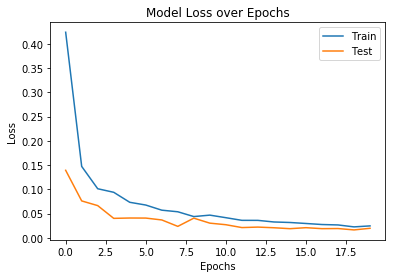

In [133]:
# Loss as a function of number of Epochs
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

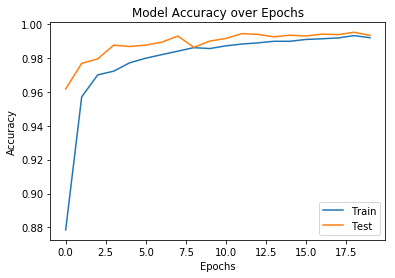

In [134]:
# Accuracy as a function of number of Epochs
plt.plot(model_fit.history['acc'])
plt.plot(model_fit.history['val_acc'])
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

Both Validation Accuracy and Training Accuracy converge and finally are close enough at the end. This indicates that our model is not Overfitting the Data.

# 5.2) Confusion Matrix

Classification accuracy alone can be misleading if you have an unequal number of observations in each class or if you have more than two classes in your dataset. So we still need to check Confusion Matrix, which calculating a confusion matrix can give you a better idea of what your classification model is getting right and what types of errors it is making.  
A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. It gives you insight not only into the errors being made by your classifier but more importantly the types of errors that are being made. It overcomes the limitation of using classification accuracy alone.

In [135]:
def plot_confusion_matrix(cm, classes, normalize, title, cmap):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize = True`.
    """
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], 
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

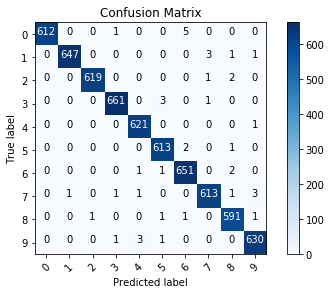

In [136]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(cm = confusion_mtx, 
                      classes = range(10), 
                      normalize = False, 
                      title = 'Confusion Matrix', 
                      cmap = plt.cm.Blues)

We can see that our CNN performs pretty good on all digits with few errors considering the size of the validation set (4 200 images). However, it still make errors at (4, 9), (0, 6), (1, 7) and (7. 9) digits. let's explore the missclassifications. 

# 5.3) Missclassification

Let's check the most important errors.

In [166]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 6 images 
    with their predicted and real labels"""
    n = 0
    nrows = 3
    ncols = 3
    fig = plt.figure(figsize=(10,10))
    fig, ax = plt.subplots(nrows,ncols,
                           sharex = True,
                           sharey = True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],
                                                                               obs_errors[error]))
            n += 1


In [139]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = x_test[errors]

<Figure size 720x720 with 0 Axes>

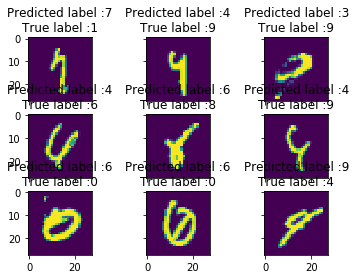

In [167]:
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, 
                                       Y_true_errors, 
                                       axis = 1))
# Difference between the probability of the predicted label and true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)
# Top 6 errors 
most_important_errors = sorted_dela_errors[-9:]
# Show the top 6 errors
display_errors(most_important_errors, 
               X_val_errors, 
               Y_pred_classes_errors, 
               Y_true_errors)

Here we get the top 9 missclassifications.  And we can see that the most important errors are also the most intrigous. So for those 9 case, the model is not bad. Some of these errors can also be made by humans, especially for one the 9 that is very close to a 4. We can still go with our current model. 

# 6. CSV Generation

In [168]:
# predict results
results = model.predict(test)
# select the indix with the maximum probability
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

In [169]:
# output CSV
submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"), results], axis = 1)
submission.to_csv("cnn_mnist_datagen.csv",index = False)